# Problem Formulation

Create a model for semantic segmentation for images containing cell neuclei.

Data originated from : https://www.kaggle.com/competitions/data-science-bowl-2018/overview

However we are using data that has been reduced.

603 files in train, 67 files in test.

We will split the train files into train and validation files. Predict on test files.

Images and masks will be filpped.

MobileNetV2 for downsampling path, upsampling path built with pix2pix.

High learning rate with reduction on validation loss plateau provides good model fit.

# Data Preparation

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 167, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py", line 339, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 75, in resolve
    collected = self.factory.collect_root_requirements(root_reqs)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/resolution/resolvelib/factory.py", line 506, in collect_root_requirements
    req = self._make_requirement_from_install_req(
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/resolution/resolvelib/factory.py", line 468, in _make_requirement_from_inst

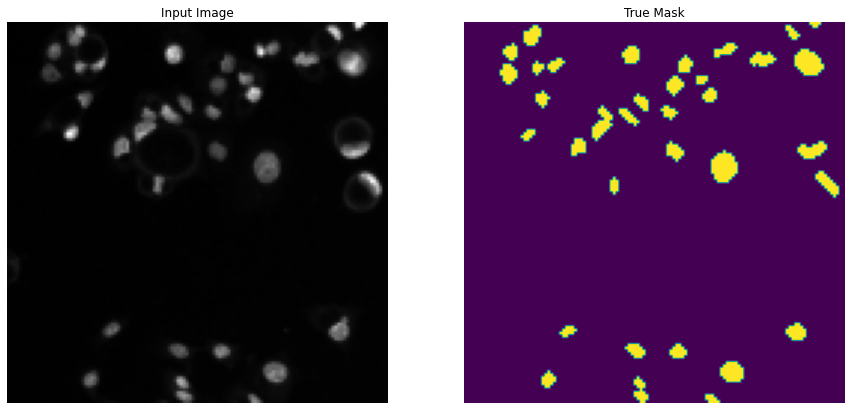

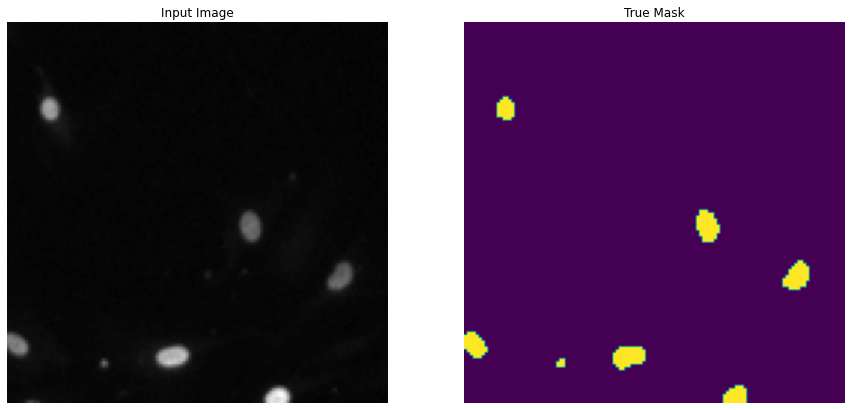

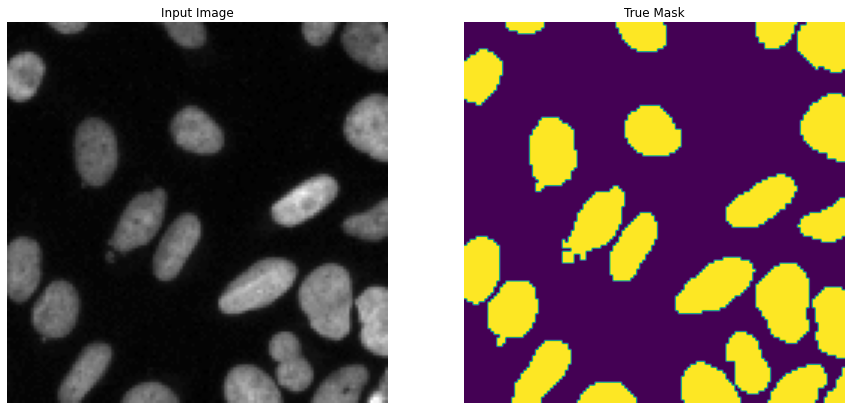

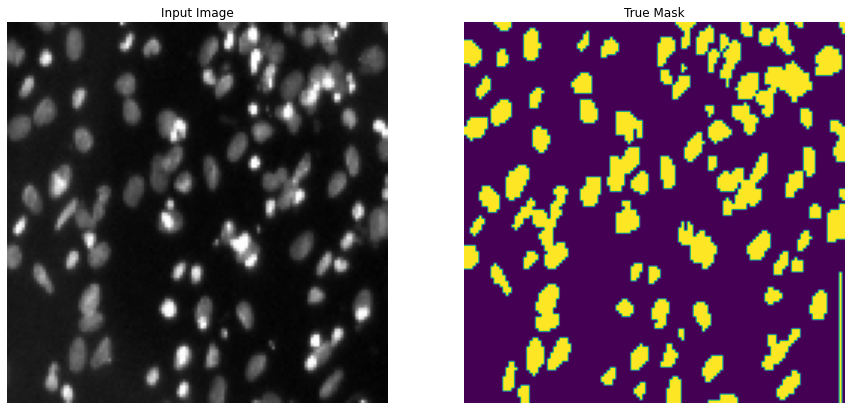

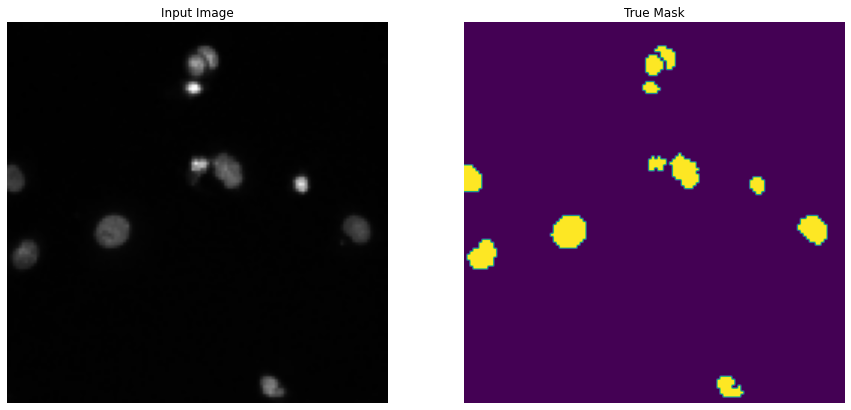

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers,losses,metrics,callbacks,applications
#!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import numpy as np
import cv2,os,re,glob,datetime
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from helper import find, image_to_array, display, create_mask

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=135):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

ZIP_PATH = find('data-science-bowl-2018.zip')

# unzip file
with ZipFile(ZIP_PATH, 'r') as zObject:
    zObject.extractall(
        path=os.getcwd())
 
DATA_PATH = os.path.join(os.getcwd(),'data-science-bowl-2018-2')
TRAIN_PATH = os.path.join(DATA_PATH,'train')
TEST_PATH = os.path.join(DATA_PATH,'test')

train_image_dir = os.path.join(TRAIN_PATH,'inputs')
train_masks_dir = os.path.join(TRAIN_PATH,'masks')
test_image_dir = os.path.join(TEST_PATH,'inputs')
test_masks_dir = os.path.join(TEST_PATH,'masks')
train_images,train_masks = image_to_array(train_image_dir,train_masks_dir)
test_images,test_masks = image_to_array(test_image_dir,test_masks_dir)

# mask processing
# expand dim for channel
train_masks_np_exp = np.expand_dims(train_masks,axis=-1)
test_masks_np_exp = np.expand_dims(test_masks,axis=-1)
# convert to 0 and 1 for all pixels to be truly black and white
train_converted_masks = np.round(train_masks_np_exp/255.0).astype(np.int64)
test_converted_masks = np.round(test_masks_np_exp/255.0).astype(np.int64)
print('Unique mask pixels',np.unique(train_masks_np_exp[0]),
      'converted to',np.unique(train_converted_masks[0]))

# image processing
# normalize pixel values in images
train_converted_images = train_images/255.0
test_converted_images = test_images/255.0

# TEST files will be use for predicting later
# TRAIN files are used for training and validation

X_train,X_test,y_train,y_test = train_test_split(train_converted_images,train_converted_masks,test_size=0.2,
                                                 random_state=123)

X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((X_train_tensor,y_train_tensor))
test_dataset = tf.data.Dataset.zip((X_test_tensor,y_test_tensor))

BATCH_SIZE = 64
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE
TRAIN_SIZE = len(train_dataset)
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE

# apply augmentation to train_batches
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)

# view augmented train_batches
for images, masks in train_batches.take(5):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# Model Development

1/1 [==============================] - 2s 2s/step


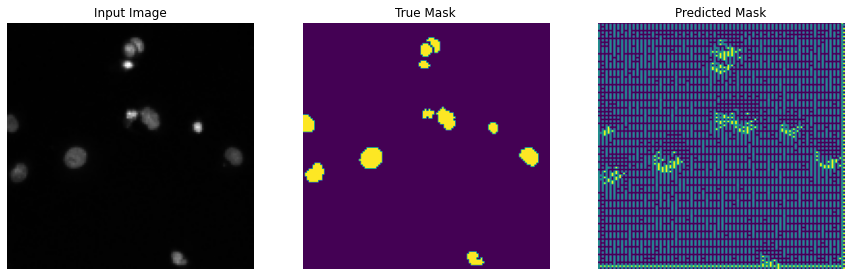

Epoch 1/50
7/7 [==============================] - 5s 527ms/step - loss: 0.8386 - accuracy: 0.7997 - val_loss: 18.9296 - val_accuracy: 0.4345 - lr: 0.0100
Epoch 2/50
7/7 [==============================] - 3s 332ms/step - loss: 0.3960 - accuracy: 0.8531 - val_loss: 2.4720 - val_accuracy: 0.6963 - lr: 0.0100
Epoch 3/50
7/7 [==============================] - 3s 405ms/step - loss: 0.3241 - accuracy: 0.8713 - val_loss: 0.9523 - val_accuracy: 0.7883 - lr: 0.0100
Epoch 4/50
7/7 [==============================] - 3s 416ms/step - loss: 0.2579 - accuracy: 0.8863 - val_loss: 0.4062 - val_accuracy: 0.8566 - lr: 0.0100
Epoch 5/50
7/7 [==============================] - 4s 508ms/step - loss: 0.1835 - accuracy: 0.9176 - val_loss: 0.3169 - val_accuracy: 0.9149 - lr: 0.0100
Epoch 6/50
7/7 [==============================] - 3s 499ms/step - loss: 0.1621 - accuracy: 0.9307 - val_loss: 0.3181 - val_accuracy: 0.9154 - lr: 0.0100
Epoch 7/50
7/7 [==============================] - 3s 462ms/step - loss: 0.1418 - 

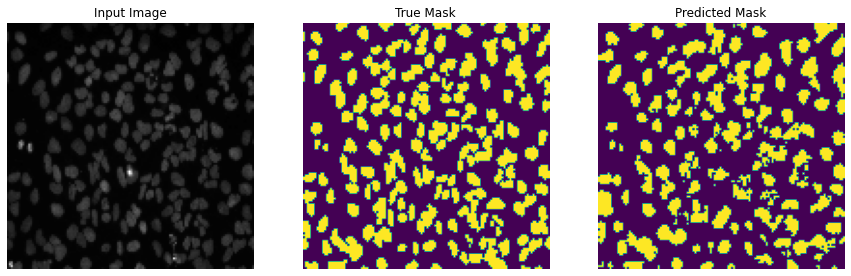

2/2 [==============================] - 0s 381ms/step


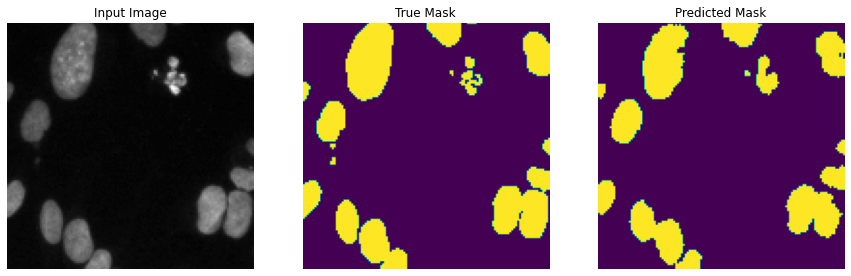

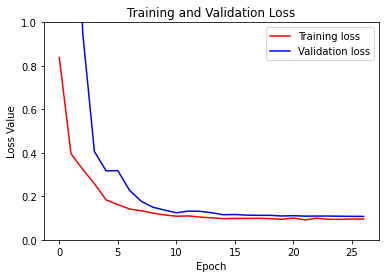

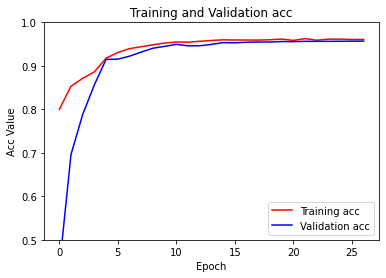

In [3]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

OUTPUT_CLASSES = 3

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])
  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(output_channels=OUTPUT_CLASSES)
opt = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'], run_eagerly=True)

# show image, actual mask and predicted mask
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                    create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

# specify callbacks
log_path = os.path.join('log_dir',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = callbacks.TensorBoard(log_dir=log_path)
es = callbacks.EarlyStopping(monitor='loss', patience=5,restore_best_weights=True,verbose=1)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.0001)

EPOCHS = 50
model_history = model.fit(train_batches, epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data=test_batches,
                        callbacks=[tb,es,rlr])

# show validation results
show_predictions(test_batches, 3)

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig('Loss.png')
plt.show()

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, acc, 'r', label='Training acc')
plt.plot(model_history.epoch, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Acc Value')
plt.ylim([0.5, 1])
plt.legend()
plt.savefig('Accuracy.png')
plt.show()

# plot performance of model and save image
# plot model architecture and save image
plot_model(model, show_shapes=True, show_layer_names=True)

# save model
model.save('model.h5')

# Model Deployment

2/2 [==============================] - 0s 93ms/step


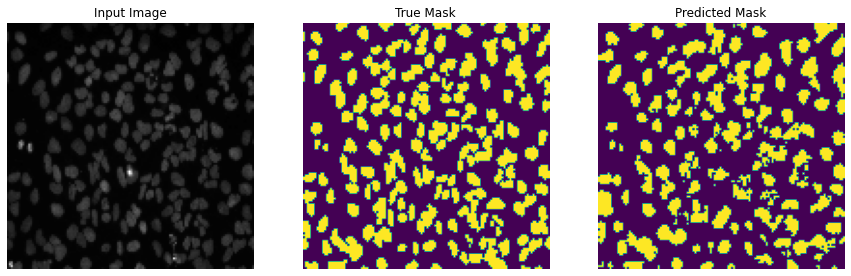

2/2 [==============================] - 0s 98ms/step


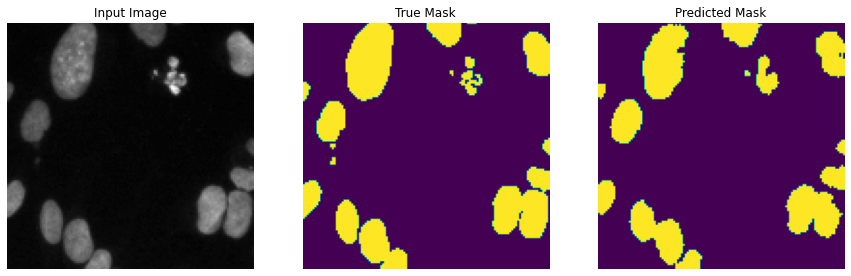

In [4]:
# predicting
X_test_true_tensor = tf.data.Dataset.from_tensor_slices(test_converted_images)
y_test_true_tensor = tf.data.Dataset.from_tensor_slices(test_converted_masks)
true_test_dataset = tf.data.Dataset.zip((X_test_true_tensor,y_test_true_tensor))
true_test_batches = test_dataset.batch(BATCH_SIZE)
model.evaluate(true_test_batches)
show_predictions(true_test_batches,num=2)